# Descriptor
#### This notebook showcases the functions used in descriptor analysis. 
#### That is, determining the keypoints descriptor or unqiue identifier. 
#### This descriptor is composed of the orientation histograms in local neighborhoods near the keypoint.

## Imports

In [1]:
# Handles relative import
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import const
import octaves as octaves_lib
import keypoints as keypoints_lib
import reference_orientation as reference_lib
import descriptor as descriptor_lib

## Find a Keypoint

In [2]:
img = cv2.imread('../images/box_in_scene.png', flags=cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img = img[0:300, 100:400]

octave_idx = 4
gauss_octaves = octaves_lib.build_gaussian_octaves(img)
gauss_octave = gauss_octaves[octave_idx]
dog_octave = octaves_lib.build_dog_octave(gauss_octave)
extrema = octaves_lib.find_dog_extrema(dog_octave)
keypoint_coords = keypoints_lib.find_keypoints(extrema, dog_octave)
keypoints = reference_lib.assign_reference_orientations(keypoint_coords, gauss_octave, octave_idx)
keypoint = keypoints[0]

magnitudes, orientations = reference_lib.gradients(gauss_octave)
coord = keypoint.coordinate
sigma = keypoint.sigma
shape = gauss_octave.shape
s, y, x = coord.round().astype(int)

pixel_dist = octaves_lib.pixel_dist_in_octave(octave_idx)
max_width = (np.sqrt(2) * const.descriptor_locality * sigma) / pixel_dist
max_width = max_width.round().astype(int)

in_frame = descriptor_lib.patch_in_frame(coord, max_width, shape)
print(f'This keypoint is in frame: {in_frame}')

This keypoint is in frame: True


## Relative Coordinates  
At this point, a keypoint has an orientation (see notebook 3).    
This orientation becomes the local neighborhoods x axis.   
In other words, there is a change of reference frame.  
This is visualized here by showing each points relative x and y coordinate.

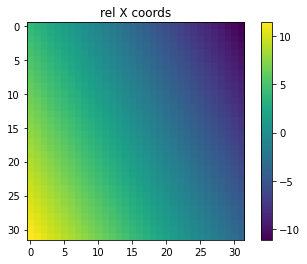

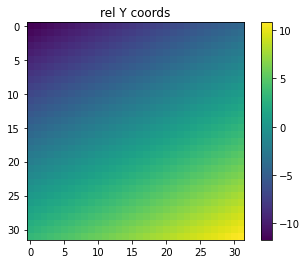

In [3]:
orientation_patch = orientations[s,
                                 y - max_width: y + max_width,
                                 x - max_width: x + max_width]
magnitude_patch = magnitudes[s,
                             y - max_width: y + max_width,
                             x - max_width: x + max_width]
patch_shape = magnitude_patch.shape
center_offset = [coord[1] - y, coord[2] - x]
rel_patch_coords = descriptor_lib.relative_patch_coordinates(center_offset, patch_shape, pixel_dist, sigma, keypoint.orientation)
plt.imshow(rel_patch_coords[1])
plt.title(f'rel X coords')
plt.colorbar()
plt.show()

plt.imshow(rel_patch_coords[0])
plt.title(f'rel Y coords')
plt.colorbar()
plt.show()


## Gaussian Weighting of Neighborhood

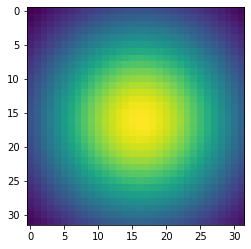

In [4]:
magnitude_patch = descriptor_lib.mask_outliers(magnitude_patch, rel_patch_coords, const.descriptor_locality)
orientation_patch = (orientation_patch - keypoint.orientation) % (2 * np.pi)
weights = descriptor_lib.weighting_matrix(center_offset, patch_shape, octave_idx, sigma, const.descriptor_locality)
plt.imshow(weights)

# Descriptor Patch

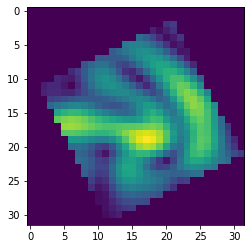

In [5]:
magnitude_patch = magnitude_patch * weights
plt.imshow(magnitude_patch)

# Descriptor Patch of Each Histogram

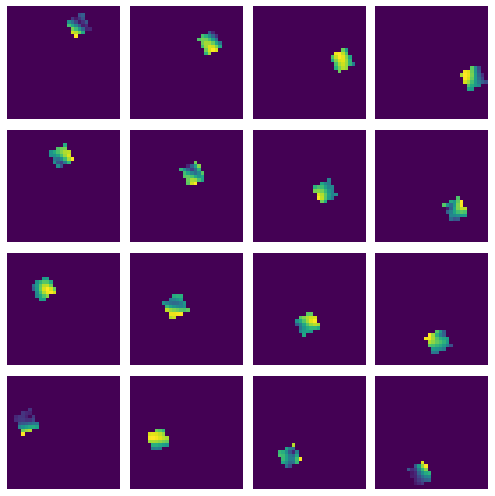

In [6]:
coords_rel_to_hists = rel_patch_coords[None] - descriptor_lib.histogram_centers[..., None, None]
hists_magnitude_patch = descriptor_lib.mask_outliers(magnitude_patch[None], coords_rel_to_hists, const.inter_hist_dist, 1)

nr_cols = 4 
fig, axs = plt.subplots(nr_cols, nr_cols, figsize=(7, 7))

for idx, masked_magntiude in enumerate(hists_magnitude_patch): 
    row = idx // nr_cols
    col = idx % nr_cols
    axs[row, col].imshow(masked_magntiude)
    axs[row, col].axis('off')

plt.tight_layout()

## Histograms to SIFT Feature

In [7]:
hists_magnitude_patch = descriptor_lib.interpolate_2d_grid_contribution(hists_magnitude_patch, coords_rel_to_hists)
hists = descriptor_lib.interpolate_1d_hist_contribution(hists_magnitude_patch, orientation_patch)
sift_feature = descriptor_lib.normalize_sift_feature(hists.ravel())

## Visualize Descriptor on Input Image

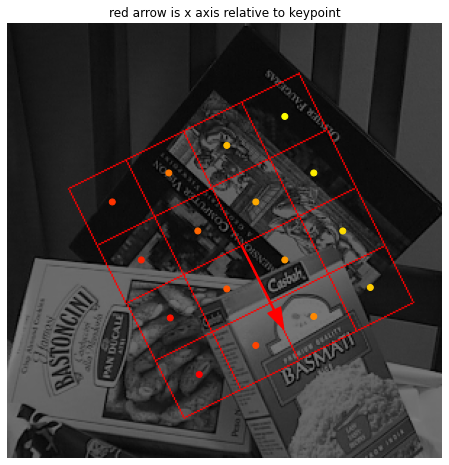

The red arrow represtns a rotation of 63.28079854101854 degrees.


In [8]:
abs_coord = keypoint.absolute_coordinate[1:][::-1]
coord = keypoint.coordinate
sigma = keypoint.sigma
shape = gauss_octave.shape
s, y, x = coord.round().astype(int)
center_offset = [coord[1] - y, coord[2] - x]
pixel_dist = octaves_lib.pixel_dist_in_octave(octave_idx)
width = const.descriptor_locality * sigma
theta = keypoint.orientation
c, s = np.cos(theta), np.sin(theta)
rot_mat = np.array(((c, -s), (s, c)))
arrow = np.matmul(rot_mat, np.array([1, 0])) * 50

hist_centers = descriptor_lib.histogram_centers.T
hist_centers = hist_centers * sigma 
hist_centers = np.matmul(rot_mat, hist_centers)
hist_centers = (hist_centers + abs_coord[:,None]).round().astype(int)
color = (1, 0, 0)

darkened = cv2.addWeighted(img, 0.5, np.zeros(img.shape, img.dtype),0,0)
col_img =  cv2.cvtColor(darkened, cv2.COLOR_GRAY2RGB)

# Horizontal lines
for i in range(5):
    offset = np.array([0, width/2]) * i
    l = np.array([-width, -width]) + offset
    r = np.array([width, -width]) + offset
    l = (np.matmul(rot_mat, l) + abs_coord).round().astype(int)
    r = (np.matmul(rot_mat, r) + abs_coord).round().astype(int) 
    col_img = cv2.line(col_img, l, r, color=color, thickness=1)
    
# Vertical lines
for i in range(5): 
    offset = np.array([width/2, 0]) * i
    t = np.array([-width, -width]) + offset
    b = np.array([-width, width]) + offset
    t = (np.matmul(rot_mat, t) + abs_coord).round().astype(int)
    b = (np.matmul(rot_mat, b) + abs_coord).round().astype(int) 
    col_img = cv2.line(col_img, t, b, color=color, thickness=1)

plt.figure(figsize=(8, 8))
plt.imshow(col_img)
plt.axis('off')
plt.title('red arrow is x axis relative to keypoint')
xs, ys = hist_centers
plt.scatter(xs, ys, c=[x for x in range(len(xs))], cmap='autumn_r')
plt.arrow(abs_coord[0], abs_coord[1], arrow[0], arrow[1], color='red', width=1, head_width=10)
plt.show()

print(f'The red arrow represtns a rotation of {np.rad2deg(keypoint.orientation)} degrees.')

# Histogram Content

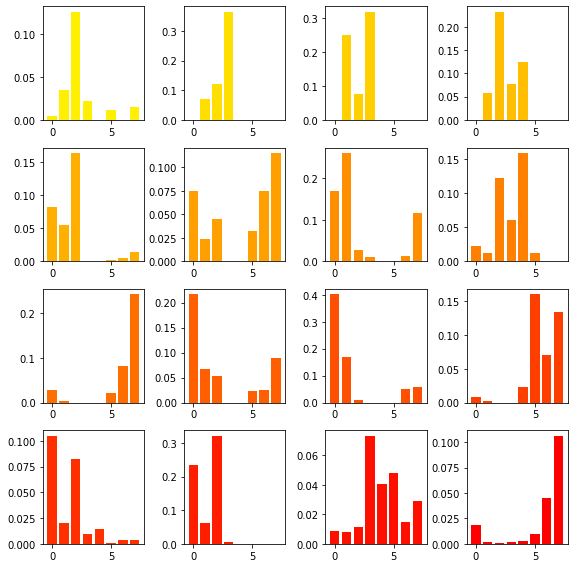

In [9]:
cmap = matplotlib.cm.get_cmap('autumn_r')
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for idx, hist in enumerate(hists): 
    row = idx // 4
    col = idx % 4
    color = cmap((idx + 1) / len(hists))
    axs[row, col].bar(list(range(const.nr_descriptor_bins)), hist, color=color)

plt.tight_layout()
plt.show()

## The SIFT feature a.k.a Concatenated Histograms

<BarContainer object of 128 artists>

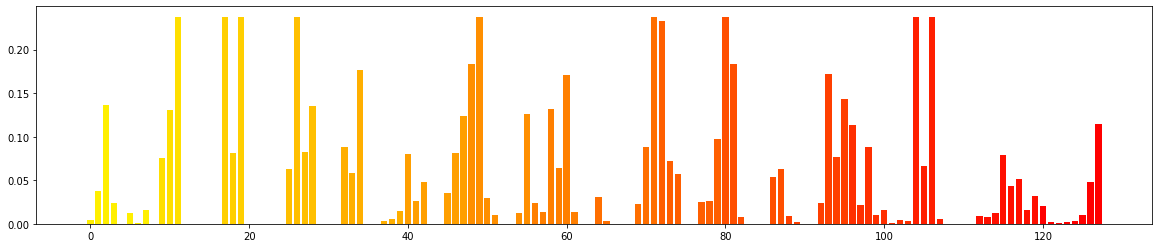

In [10]:
colors = [cmap((idx+1) / len(hists)) for idx in range(16)]
colors = np.repeat(colors, const.nr_descriptor_bins, axis=0)
plt.figure(figsize=(20, 4))
plt.bar(range(len(sift_feature)), sift_feature, color=colors)
